# Assignment 2

## Instructions
- Your submission should be the `.ipynb` file with your name,
  like `YusufMesbah.ipynb`. it should include the answers to the questions in
  markdown cells.
- You are expected to follow the best practices for code writing and model
training. Poor coding style will be penalized.
- You are allowed to discuss ideas with your peers, but no sharing of code.
Plagiarism in the code will result in failing. If you use code from the
internet, cite it.
- If the instructions seem vague, use common sense.

# Task 1: ANN (30%)
For this task, you are required to build a fully connect feed-forward ANN model
for a multi-label regression problem.

For the given data, you need do proper data preprocessing, design the ANN model,
then fine-tune your model architecture (number of layers, number of neurons,
activation function, learning rate, momentum, regularization).

For evaluating your model, do $80/20$ train test split.

### Data
You will be working with the data in `Task 1.csv` for predicting students'
scores in 3 different exams: math, reading and writing. The columns include:
 - gender
 - race
 - parental level of education
 - lunch meal plan at school
 - whether the student undertook the test preparation course

## Import dataset

In [338]:
import pandas as pd
import numpy as np

# Read data set
data = pd.read_csv('Task 1.csv')
print(data.shape)
data.head()

(1000, 8)


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,male,group A,high school,standard,completed,67,67,63
1,female,group D,some high school,free/reduced,none,40,59,55
2,male,group E,some college,free/reduced,none,59,60,50
3,male,group B,high school,standard,none,77,78,68
4,male,group E,associate's degree,standard,completed,78,73,68


## Check columns and prepare them for encoding

In [339]:
# Check count of distinct values in columns gender, lunch
gender_col = data['gender'].unique()
print(data['gender'].nunique(), gender_col)

lunch_col = data['lunch'].unique()
print(data['lunch'].nunique(), lunch_col)

course_col = data['test preparation course'].unique()
print(data['test preparation course'].nunique(), course_col)

race_col = data['race/ethnicity'].unique()
race_col.sort()
print(data['race/ethnicity'].nunique(), race_col)

level_col = data['parental level of education'].unique()
print(data['parental level of education'].nunique(), level_col)

# Array of orginized parental level of education
level_col = ['some high school', 'high school', 'some college', 'associate\'s degree', 'bachelor\'s degree', 'master\'s degree']

print('\nOrginized parental level of education: ', level_col)

2 ['male' 'female']
2 ['standard' 'free/reduced']
2 ['completed' 'none']
5 ['group A' 'group B' 'group C' 'group D' 'group E']
6 ['high school' 'some high school' 'some college' "associate's degree"
 "bachelor's degree" "master's degree"]

Orginized parental level of education:  ['some high school', 'high school', 'some college', "associate's degree", "bachelor's degree", "master's degree"]


## Encode columns

In [340]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

# Create encoder
ordinalEncoder = OrdinalEncoder(categories=[race_col, level_col])
oneHotEncoder = OneHotEncoder()

ordinal_features = ['race/ethnicity', 'parental level of education']
one_hot_features = ['gender', 'lunch', 'test preparation course']

In [341]:
# Encode ordinal features
new_oe_features = ordinalEncoder.fit_transform(data[ordinal_features])
new_oe_cols = pd.DataFrame(new_oe_features, dtype=int, columns=ordinal_features)

In [342]:
# Encode one hot features
new_ohe_features = oneHotEncoder.fit_transform(data[one_hot_features])
new_ohe_cols = pd.DataFrame(new_ohe_features.toarray(), dtype=int, columns=oneHotEncoder.get_feature_names(one_hot_features))

C:\Users\Dale\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Combine new columns into new dataset

In [343]:
# Combine all features
new_data = pd.concat([data], axis=1)
new_data = new_data.drop(columns=ordinal_features + one_hot_features )
new_data = pd.concat([new_data, new_oe_cols, new_ohe_cols], axis=1)
new_data.head()

,math score,reading score,writing score,race/ethnicity,parental level of education,gender_female,gender_male,lunch_free/reduced,lunch_standard,test preparation course_completed,test preparation course_none
0,67,67,63,0,1,0,1,0,1,1,0
1,40,59,55,3,0,1,0,1,0,0,1
2,59,60,50,4,2,0,1,1,0,0,1
3,77,78,68,1,1,0,1,0,1,0,1
4,78,73,68,4,3,0,1,0,1,1,0


## Split dataset

In [344]:
from sklearn.model_selection import train_test_split

# Split data to target and features
X = new_data.iloc[:, 3:].values
y = new_data.iloc[:, :3].values

# Split data to training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

## Scale features

In [345]:
from sklearn.preprocessing import StandardScaler

# Scale testing and training data
scaler = StandardScaler()
scaler.fit(X_train)

# Create Data Frames with scaled data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [346]:
# # Scale target data
# target_scaler = StandardScaler()
# target_scaler.fit(y_train)

# # Create Data Frames with scaled data
# y_train = target_scaler.transform(y_train)
# y_test = target_scaler.transform(y_test)

## Create custom dataset for pytorch

In [347]:
import torch
from torch.utils.data import Dataset, DataLoader

# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.y = torch.tensor(y).float()
        self.X = torch.tensor(X).float()

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx, :], self.y[idx]

In [348]:
batch_size = 32

train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False)

In [349]:
data, label = next(iter(train_dataloader))
label.shape

torch.Size([32, 3])

## Create ANN model and prepare device

In [350]:
use_cuda = torch.cuda.is_available()
print("cuda" if use_cuda else "cpu")
device = torch.device("cuda" if use_cuda else "cpu")

cuda


In [351]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Custom neural network class
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.hidden1 = nn.Linear(8, 4)
        self.output = nn.Linear(4, 3)

    def forward(self, x):
        x = F.leaky_relu(self.hidden1(x))
        x = self.output(x)
        return x

# Create neural network
model = ANN().to(device)

print(model)

ANN(
  (hidden1): Linear(in_features=8, out_features=4, bias=True)
  (output): Linear(in_features=4, out_features=3, bias=True)
)


In [352]:
epochs = 100
lr = 0.001
momentum = 0.9
seed = 1
log_interval = 4

loss_fn = nn.MSELoss(reduction='mean')

## Create functions for accuracy and debug

In [353]:
# Function to compare first element in batch with the first target value 
def print_batch_element_error(batch, target):
    # get value from tensor
    batch = batch.cpu().data.numpy()
    target = target.cpu().data.numpy()
    predicted_v = batch[0]
    target_v = target[0]
    error = np.abs(predicted_v - target_v)
    print('Predicted: ', predicted_v, 'Target: ', target_v, 'Error: ', error, '\n')


# Custom accuracy function
def task1_accuracy(output, target, threshold=2):
    output = output.cpu().data.numpy()
    target = target.cpu().data.numpy()
    # output = target_scaler.inverse_transform(output)
    # target = target_scaler.inverse_transform(target)
    accuracy = 0
    for i in range(len(output)):
        predicted_v = output[i]
        target_v = target[i]
        error = np.abs(predicted_v - target_v)
        for j in range(len(error)):
            if error[j] <= threshold:
                error[j] = 1
            else:
                error[j] = 0
        accuracy += np.sum(error)/3
    
    return accuracy/len(output)

## Prepare EarlyStopping

In [354]:
import operator

class EarlyStopping():
    def __init__(self, tolerance=5, min_delta=0, mode='min'):
        self.tolerance = tolerance
        self.min_delta = min_delta
        self.mode = mode
        self.counter = 0
        self.early_stop = False
        self.prev_metric = np.inf if mode == 'min' else -np.inf

        self.operation = operator.gt if mode == 'min' else operator.lt

    def __call__(self, metric):
        delta = (metric - self.prev_metric)

        if self.operation(delta, self.min_delta):
            self.counter +=1
        else:
            self.counter = 0
            self.prev_metric = metric

        if self.counter >= self.tolerance:
            self.early_stop = True
        return self.early_stop

## Function to train model

In [355]:
def train(model, device, train_loader, optimizer, epoch, loss_func, accuracy_func = None, task = 1):
    model.train()
    epoch_loss = 0
    accuracy = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad() 
        output = model(data).squeeze()
        # print('Output: ', output)
        # print('Target: ', target)
        # print(output.shape)
        # print(target.shape)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        if accuracy_func:
            curr_accuracy = accuracy_func(output, target)
            accuracy += curr_accuracy

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                        100. * batch_idx / len(train_loader), loss.item()), end='')
            if accuracy_func:
                print('\tAccuracy: {:.6f}'.format(curr_accuracy), end='')
            print()

    # Print average scores for epoch
    if task == 1:
        epoch_loss /= len(train_loader.dataset)
    elif task == 2:
        epoch_loss /= len(train_loader)

    print('\nTrain Epoch: Average Loss: {:.6f}'.format(epoch_loss), end='')
    
    if accuracy_func:
        print('\tAverage Accuracy: {:.6f}'.format(accuracy/len(train_loader)), end='')
    print()

## Function to test/validate model

In [356]:
def test(model, device, test_loader, loss_func, accuracy_func, task = 1, set_name = 'Test'):
    model.eval()
    test_loss = 0
    accuracy = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data).squeeze()
            test_loss += loss_func(output, target).item()
            accuracy += accuracy_func(output, target)

    if task == 1:
        test_loss /= len(test_loader.dataset)
    elif task == 2:
        test_loss /= len(test_loader)
    

    print('\n{} set: Average loss: {:.4f} Average accuracy: {:.4f}\n'.format(
        set_name, test_loss, accuracy / len(test_loader)))

    return test_loss

## Train and test ANN model

In [357]:
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
early_stopping = EarlyStopping()

for epoch in range(1, epochs + 1):
    train(model, device, train_dataloader, optimizer, epoch, loss_fn, task1_accuracy)
    test_loss = test(model, device, test_dataloader, loss_fn, task1_accuracy)

    if early_stopping(test_loss):
        break

Train Epoch: 1 [0/800 (0%)]	Loss: 4904.065430	Accuracy: 0.000000
Train Epoch: 1 [128/800 (16%)]	Loss: 4957.311523	Accuracy: 0.000000
Train Epoch: 1 [256/800 (32%)]	Loss: 4201.226562	Accuracy: 0.000000
Train Epoch: 1 [384/800 (48%)]	Loss: 3714.946777	Accuracy: 0.000000
Train Epoch: 1 [512/800 (64%)]	Loss: 1244.681641	Accuracy: 0.020833
Train Epoch: 1 [640/800 (80%)]	Loss: 1561.835938	Accuracy: 0.020833
Train Epoch: 1 [768/800 (96%)]	Loss: 442.847839	Accuracy: 0.041667

Train Epoch: Average Loss: 94.811380	Average Accuracy: 0.018333

Test set: Average loss: 21.3818 Average accuracy: 0.0580

Train Epoch: 2 [0/800 (0%)]	Loss: 655.039185	Accuracy: 0.031250
Train Epoch: 2 [128/800 (16%)]	Loss: 821.732910	Accuracy: 0.031250
Train Epoch: 2 [256/800 (32%)]	Loss: 522.695190	Accuracy: 0.083333
Train Epoch: 2 [384/800 (48%)]	Loss: 440.646851	Accuracy: 0.083333
Train Epoch: 2 [512/800 (64%)]	Loss: 320.158691	Accuracy: 0.072917
Train Epoch: 2 [640/800 (80%)]	Loss: 252.775848	Accuracy: 0.083333
Train

### Questions
1. What preprocessing techniques did you use? Why?
    - *Answer*
2. Describe the fine-tuning process and how you reached your model architecture.
    - *Answer*

# Task 2: CNN (40%)
For this task, you will be doing image classification:
- First, adapt your best model from Task 1 to work on this task, and
fit it on the new data. Then, evaluate its performance.
- After that, build a CNN model for image classification.
- Compare both models in terms of accuracy, number of parameters and speed of
inference (the time the model takes to predict 50 samples).

For the given data, you need to do proper data preprocessing and augmentation,
data loaders.
Then fine-tune your model architecture (number of layers, number of filters,
activation function, learning rate, momentum, regularization).

### Data
You will be working with the data in `triple_mnist.zip` for predicting 3-digit
numbers writen in the image. Each image contains 3 digits similar to the
following example (whose label is `039`):

![example](https://github.com/shaohua0116/MultiDigitMNIST/blob/master/asset/examples/039/0_039.png?raw=true)

## Data preprocessing and augmentation

In [358]:
from torchvision import transforms
from torchvision.datasets import ImageFolder

test_path = './triple_mnist/triple_mnist/test/'
train_path = './triple_mnist/triple_mnist/train/'
val_path = './triple_mnist/triple_mnist/val/'

batch_size = 64

train_transform = transforms.Compose([
    transforms.Resize(84),
    transforms.Grayscale(),
    # transforms.RandomRotation(degrees=(-2, 2)),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(84),
    transforms.Grayscale(),
    transforms.ToTensor()
])

train_data = ImageFolder(root=train_path, transform=train_transform)

test_data = ImageFolder(root=test_path, transform=test_transform)

val_data = ImageFolder(root=val_path, transform=test_transform)

In [359]:
def fix_data_targets(data):
    classes = data.classes
    for i in range(len(data.samples)):
        path, index = data.samples[i]
        cl = classes[index]
        arr = np.zeros((3,), dtype=np.int64)
        for j in range(len(cl)):
            arr[j] = int(cl[j])
        new_sample = (path, arr)
        data.samples[i] = new_sample
        data.targets[i] = arr

In [360]:
fix_data_targets(train_data)
fix_data_targets(test_data)
fix_data_targets(val_data)

In [361]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

## Show one sample from dataset

In this part I get number of input channels and show first image from batch

torch.Size([64, 1, 84, 84]) 7056 1


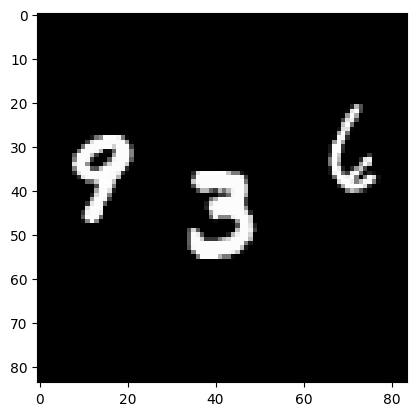

In [362]:
import matplotlib.pyplot as plt
images, labels = next(iter(train_loader))

in_channels = images.shape[1]
images_shape = np.prod(images.shape[1:])

print(images.shape, images_shape, in_channels)
plt.imshow(np.transpose(images[0].cpu().detach().numpy(), (1, 2, 0)), cmap='gray')

## Prepare ANN from the first task for new data

In [363]:
class ANN_2(ANN):
    def __init__(self):
        super(ANN_2, self).__init__()
        self.hidden1 = nn.Linear(images_shape, 2500)
        self.output = nn.Linear(2500, 30)
        
    def forward(self, x):
        x = x.view(-1, images_shape)
        x = F.leaky_relu(self.hidden1(x))
        x = self.output(x)
        x = F.log_softmax(x, dim=1)
        x = x.view(-1, 3, 10)
        x = x.transpose(1, 2)
        return x

In [364]:
model = ANN_2().to(device)
print(model)

ANN_2(
  (hidden1): Linear(in_features=7056, out_features=2500, bias=True)
  (output): Linear(in_features=2500, out_features=30, bias=True)
)


## Update epochs number and loss function

In this task I decide to check ANN model without changing learning rate and momentum. As we asked to change only input and output layers.

In [365]:
epochs = 1
log_interval = 20

loss_fn = nn.NLLLoss()
# loss_fn = nn.CrossEntropyLoss()

## Create a custom function for accuracy

In [366]:
def task2_accuracy(output, target):
    output = output.cpu().detach().numpy()
    target = target.cpu().detach().numpy()

    accuracy = 0

    for i in range(len(output)):
        out = np.transpose(output[i])
        tar = target[i]

        # print(out)
        # print(tar)

        num1 = out[0].argmax()
        num2 = out[1].argmax()
        num3 = out[2].argmax()

        # print(num1, num2, num3)

        if num1 == tar[0] and num2 == tar[1] and num3 == tar[2]:
            accuracy += 1
    
    return accuracy / len(output)

## Train, validate and test ANN model

In [367]:
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
early_stopping = EarlyStopping()

for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch, loss_fn, None, 2)
    val_loss = test(model, device, val_loader, loss_fn, task2_accuracy, 2, 'Validation')

    if early_stopping(val_loss):
        break

test_loss = test(model, device, test_loader, loss_fn, task2_accuracy, 2)

Train Epoch: 1 [0/64000 (0%)]	Loss: 3.396143
Train Epoch: 1 [1280/64000 (2%)]	Loss: 3.401229
Train Epoch: 1 [2560/64000 (4%)]	Loss: 3.401330
Train Epoch: 1 [3840/64000 (6%)]	Loss: 3.395938
Train Epoch: 1 [5120/64000 (8%)]	Loss: 3.396170
Train Epoch: 1 [6400/64000 (10%)]	Loss: 3.391620
Train Epoch: 1 [7680/64000 (12%)]	Loss: 3.388487
Train Epoch: 1 [8960/64000 (14%)]	Loss: 3.393157
Train Epoch: 1 [10240/64000 (16%)]	Loss: 3.392922
Train Epoch: 1 [11520/64000 (18%)]	Loss: 3.394390
Train Epoch: 1 [12800/64000 (20%)]	Loss: 3.390010
Train Epoch: 1 [14080/64000 (22%)]	Loss: 3.390893
Train Epoch: 1 [15360/64000 (24%)]	Loss: 3.385768
Train Epoch: 1 [16640/64000 (26%)]	Loss: 3.392180
Train Epoch: 1 [17920/64000 (28%)]	Loss: 3.393362
Train Epoch: 1 [19200/64000 (30%)]	Loss: 3.391141
Train Epoch: 1 [20480/64000 (32%)]	Loss: 3.387752
Train Epoch: 1 [21760/64000 (34%)]	Loss: 3.386425
Train Epoch: 1 [23040/64000 (36%)]	Loss: 3.386404
Train Epoch: 1 [24320/64000 (38%)]	Loss: 3.374224
Train Epoch: 1 [

## Create a CNN model

In [368]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Input image 84 x 84
        self.conv1 = nn.Conv2d(in_channels, 8, 3)  # output 82 x 82
        self.pool = nn.MaxPool2d(2, 2)  # pool function with kernel size 2 and stride 2
        self.conv1_bn = nn.BatchNorm2d(8)

        self.conv2 = nn.Conv2d(8, 16, 4)  # output 38 x 38
        self.conv2_bn = nn.BatchNorm2d(16)  # output 19 x 19

        self.conv3 = nn.Conv2d(16, 4, 3) # output 17 x 17
        self.conv3_bn = nn.BatchNorm2d(4)

        self.fc1 = nn.Linear(17 * 17 * 4, 128)
        self.fc2 = nn.Linear(128, 64)
        self.out = nn.Linear(64, 30)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))

        # print(x.shape)

        x = self.conv1_bn(x)

        # print(x.shape)

        x = self.pool(F.relu(self.conv2(x)))

        # print(x.shape)

        x = self.conv2_bn(x)

        # print(x.shape)

        x = F.relu(self.conv3(x))

        # print(x.shape)

        x = self.conv3_bn(x)

        # print(x.shape)

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        x = self.out(x)

        x = F.log_softmax(x, dim=1)
        # x = F.sigmoid(x)
        x = x.view(-1, 3, 10)
        x = x.transpose(1, 2)
        
        return x

In [369]:
# device = torch.device("cuda" if use_cuda else "cpu")
lr = 0.01
momentum = 0.5

model = CNN().to(device)
print(model)

CNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1_bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 16, kernel_size=(4, 4), stride=(1, 1))
  (conv2_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1))
  (conv3_bn): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1156, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=30, bias=True)
)


## Train, validate and test CNN model

In [370]:
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
early_stopping = EarlyStopping()

for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch, loss_fn, None, 2)
    val_loss = test(model, device, val_loader, loss_fn, task2_accuracy, 2, 'Validation')

    if early_stopping(val_loss):
        break

test_loss = test(model, device, test_loader, loss_fn, task2_accuracy, 2)

Train Epoch: 1 [0/64000 (0%)]	Loss: 3.413382
Train Epoch: 1 [1280/64000 (2%)]	Loss: 3.397486
Train Epoch: 1 [2560/64000 (4%)]	Loss: 3.400151
Train Epoch: 1 [3840/64000 (6%)]	Loss: 3.399995
Train Epoch: 1 [5120/64000 (8%)]	Loss: 3.403501
Train Epoch: 1 [6400/64000 (10%)]	Loss: 3.411619
Train Epoch: 1 [7680/64000 (12%)]	Loss: 3.394128
Train Epoch: 1 [8960/64000 (14%)]	Loss: 3.402182
Train Epoch: 1 [10240/64000 (16%)]	Loss: 3.398787
Train Epoch: 1 [11520/64000 (18%)]	Loss: 3.406830
Train Epoch: 1 [12800/64000 (20%)]	Loss: 3.381422
Train Epoch: 1 [14080/64000 (22%)]	Loss: 3.389558
Train Epoch: 1 [15360/64000 (24%)]	Loss: 3.385446
Train Epoch: 1 [16640/64000 (26%)]	Loss: 3.384447
Train Epoch: 1 [17920/64000 (28%)]	Loss: 3.382584
Train Epoch: 1 [19200/64000 (30%)]	Loss: 3.382854
Train Epoch: 1 [20480/64000 (32%)]	Loss: 3.360689
Train Epoch: 1 [21760/64000 (34%)]	Loss: 3.366872
Train Epoch: 1 [23040/64000 (36%)]	Loss: 3.370051
Train Epoch: 1 [24320/64000 (38%)]	Loss: 3.340829
Train Epoch: 1 [

### Questions
1. What preprocessing techniques did you use? Why?
    - *Answer*
2. What data augmentation techniques did you use?
    - *Answer*
3. Describe the fine-tuning process and how you reached your final CNN model.
    - *Answer*

# Task 3: Decision Trees and Ensemble Learning (15%)

For the `loan_data.csv` data, predict if the bank should give a loan or not.
You need to do the following:
- Fine-tune a decision tree on the data
- Fine-tune a random forest on the data
- Compare their performance
- Visualize your DT and one of the trees from the RF

For evaluating your models, do $80/20$ train test split.

### Data
- `credit.policy`: Whether the customer meets the credit underwriting criteria.
- `purpose`: The purpose of the loan.
- `int.rate`: The interest rate of the loan.
- `installment`: The monthly installments owed by the borrower if the loan is funded.
- `log.annual.inc`: The natural logarithm of the self-reported annual income of the borrower.
- `dti`: The debt-to-income ratio of the borrower.
- `fico`: The FICO credit score of the borrower.
- `days.with.cr.line`: The number of days the borrower has had a credit line.
- `revol.bal`: The borrower's revolving balance.
- `revol.util`: The borrower's revolving line utilization rate.

In [371]:
# TODO: Implement task 3

### Questions
1. How did the DT compare to the RF in performance? Why?
    - *Answer*
2. After fine-tuning, how does the max depth in DT compare to RF? Why?
    - *Answer*
3. What is ensemble learning? What are its pros and cons?
    - *Answer*
4. Briefly explain 2 types of boosting methods and 2 types of bagging methods.
Which of these categories does RF fall under?
    - *Answer*

# Task 4: Domain Gap (15%)

Evaluate your CNN model from task 2 on SVHN data without retraining your model.

In [372]:
# TODO: Implement task 4

### Questions
1. How did your model perform? Why is it better/worse?
    - *Answer*
2. What is domain gap in the context of ML?
    - *Answer*
3. Suggest two ways through which the problem of domain gap can be tackled.
    - *Answer*